Here, we examine functional sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

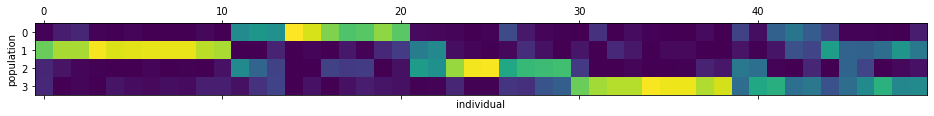

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [8]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [9]:
k_approx = 12

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [12]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 412)

In [13]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

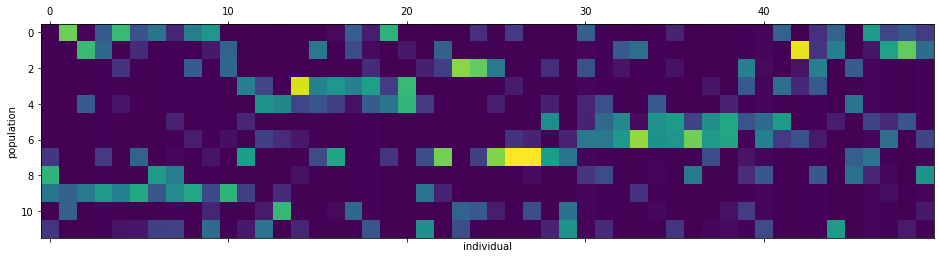

In [14]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Run CAVI

In [15]:
# get beta parameters for sticks and populations
vb_opt_dict, vb_opt, kl_vec, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami, 
                        prior_params_dict,
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 1)


CAVI compile time: 4.63sec

 running CAVI ...
iteration [1]; kl:9474.043893; elapsed: 0.0196secs
iteration [2]; kl:8821.931649; elapsed: 0.0988secs
iteration [3]; kl:8670.202314; elapsed: 0.0258secs
iteration [4]; kl:8603.955065; elapsed: 0.0155secs
iteration [5]; kl:8559.609886; elapsed: 0.015secs
iteration [6]; kl:8524.922383; elapsed: 0.0155secs
iteration [7]; kl:8495.722988; elapsed: 0.0153secs
iteration [8]; kl:8470.063419; elapsed: 0.0192secs
iteration [9]; kl:8446.957519; elapsed: 0.02secs
iteration [10]; kl:8425.899774; elapsed: 0.0163secs
iteration [11]; kl:8406.613981; elapsed: 0.0151secs
iteration [12]; kl:8388.910676; elapsed: 0.0154secs
iteration [13]; kl:8372.614378; elapsed: 0.015secs
iteration [14]; kl:8357.542789; elapsed: 0.0153secs
iteration [15]; kl:8343.525096; elapsed: 0.0156secs
iteration [16]; kl:8330.431833; elapsed: 0.0153secs
iteration [17]; kl:8318.186573; elapsed: 0.0153secs
iteration [18]; kl:8306.748463; elapsed: 0.015secs
iteration [19]; kl:8296.057555; 

iteration [162]; kl:7741.571657; elapsed: 0.0264secs
iteration [163]; kl:7741.131351; elapsed: 0.0422secs
iteration [164]; kl:7740.684122; elapsed: 0.0353secs
iteration [165]; kl:7740.230276; elapsed: 0.0368secs
iteration [166]; kl:7739.770462; elapsed: 0.0238secs
iteration [167]; kl:7739.305624; elapsed: 0.0182secs
iteration [168]; kl:7738.836912; elapsed: 0.0153secs
iteration [169]; kl:7738.365536; elapsed: 0.015secs
iteration [170]; kl:7737.892581; elapsed: 0.015secs
iteration [171]; kl:7737.418797; elapsed: 0.0166secs
iteration [172]; kl:7736.944414; elapsed: 0.0221secs
iteration [173]; kl:7736.469037; elapsed: 0.0176secs
iteration [174]; kl:7735.991647; elapsed: 0.0171secs
iteration [175]; kl:7735.510751; elapsed: 0.0176secs
iteration [176]; kl:7735.024612; elapsed: 0.0167secs
iteration [177]; kl:7734.531509; elapsed: 0.0158secs
iteration [178]; kl:7734.029964; elapsed: 0.0153secs
iteration [179]; kl:7733.518885; elapsed: 0.0152secs
iteration [180]; kl:7732.997636; elapsed: 0.0149

iteration [320]; kl:7603.969144; elapsed: 0.0204secs
iteration [321]; kl:7601.941774; elapsed: 0.0233secs
iteration [322]; kl:7599.669487; elapsed: 0.0167secs
iteration [323]; kl:7597.127615; elapsed: 0.0148secs
iteration [324]; kl:7594.293865; elapsed: 0.0152secs
iteration [325]; kl:7591.151648; elapsed: 0.0155secs
iteration [326]; kl:7587.694727; elapsed: 0.0151secs
iteration [327]; kl:7583.932931; elapsed: 0.015secs
iteration [328]; kl:7579.897893; elapsed: 0.0152secs
iteration [329]; kl:7575.646383; elapsed: 0.015secs
iteration [330]; kl:7571.257492; elapsed: 0.0153secs
iteration [331]; kl:7566.822512; elapsed: 0.0154secs
iteration [332]; kl:7562.439733; elapsed: 0.0152secs
iteration [333]; kl:7558.235975; elapsed: 0.021secs
iteration [334]; kl:7554.396875; elapsed: 0.0282secs
iteration [335]; kl:7551.140728; elapsed: 0.0276secs
iteration [336]; kl:7548.633385; elapsed: 0.0305secs
iteration [337]; kl:7546.912158; elapsed: 0.0251secs
iteration [338]; kl:7545.86747; elapsed: 0.0224se

# Check out the fit

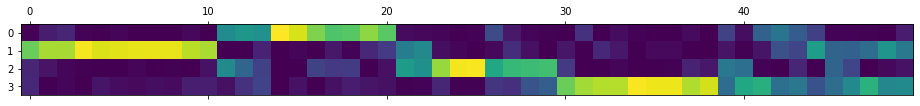

In [16]:
# truth
plt.matshow(true_ind_admix_propn.T)

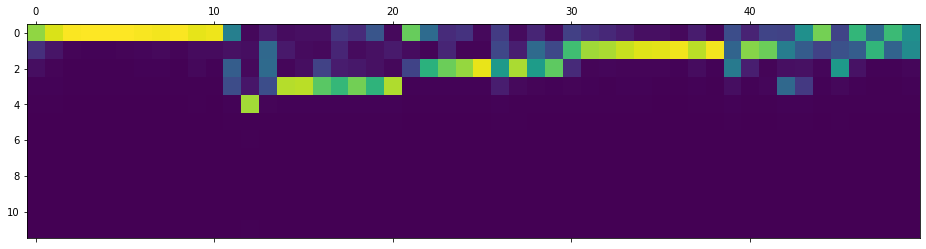

In [17]:
# fitted
e_ind_admix = get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0]
plt.matshow(e_ind_admix.T)

# Define prior perturbation

In [19]:
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

In [20]:
def log_phi(logit_v):
    return(sp.special.expit(-logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [21]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))

def rescaled_log_phi(logit_v):
    return 2 * log_phi(logit_v) / log_phi_max


In [22]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)


-1.0986122886681098 1.5674499614238597 -1.0996184973479006 1.5669044626347488


Text(0.5, 1.0, 'Priors in logit space')

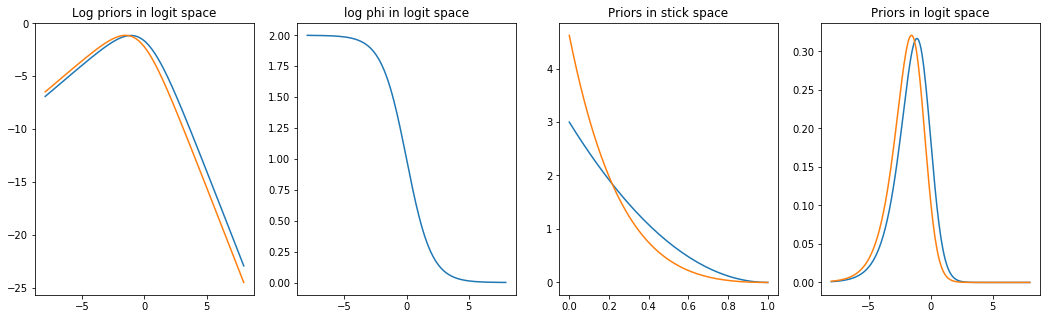

In [23]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [24]:
log_prior_pert = lambda logit_v : rescaled_log_phi(logit_v) - prior_perturbation.log_norm_pc_logit

In [25]:
prior_perturbation.log_norm_pc_logit

DeviceArray(1.56690446, dtype=float64)

In [26]:
# we will use theses for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(
                                                        g_obs, 
                                                        params,
                                                        prior_params_dict,
                                                        epsilon = epsilon,
                                                        gh_loc = gh_loc,
                                                        gh_weights = gh_weights,
                                                        log_phi = log_prior_pert,
                                                        ),
    argnums=0, patterns=vb_params_paragami, free=True)
    
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon, gh_loc, gh_weights): 
    return func_sens_lib.get_e_log_perturbation(log_phi,
                            vb_params_dict['ind_mix_stick_propn_mean'],
                            vb_params_dict['ind_mix_stick_propn_info'],
                            epsilon, gh_loc, gh_weights, sum_vector=True)


hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: get_e_log_perturbation(log_prior_pert, 
                                                    params,
                                                    epsilon,
                                                    gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [27]:
epsilon0 = np.array([0.])

In [28]:
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.468sec


In [29]:
import vittles

In [30]:
# get hessian-vector product
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [31]:
obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : get_epsilon_vb_loss(x, epsilon0)))

In [32]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': mfvb_preconditioner})


In [33]:
epsilon_sens = HyperparameterSensitivityLinearApproximation(get_epsilon_vb_loss,
                                                        vb_opt,
                                                        epsilon0, 
                                                        hyper_par_objective_fun = hyper_par_objective_fun,
                                                        hess_solver = cg_solver)


Compiling objective function derivatives ... 
Compile time: 0.26sec

Objective function derivative time: 0.000413sec

Linear system compile time: 1.61sec
Linear system time: 2.11sec


# Fit with perturbation

In [34]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  12.62270629884076


In [35]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

In [36]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [37]:
vb_pert_dict, vb_opt_pert, e_z_pert, _, _ = \
    cavi_lib.run_cavi(g_obs, deepcopy(new_init_dict), 
                        vb_params_paragami, 
                        prior_params_dict,
                        gh_loc = gh_loc, gh_weights = gh_weights,
                        max_iter = 1000,
                        x_tol = 1e-3, 
                        print_every = 20, 
                        epsilon = epsilon, log_phi = log_prior_pert)


CAVI compile time: 2.99sec

 running CAVI ...
iteration [20]; kl:7632.566749; elapsed: 0.4secs
iteration [40]; kl:7631.90689; elapsed: 0.4279secs
iteration [60]; kl:7631.753456; elapsed: 0.3041secs
iteration [80]; kl:7631.656945; elapsed: 0.4778secs
iteration [100]; kl:7631.586762; elapsed: 0.5147secs
iteration [120]; kl:7631.559159; elapsed: 0.3094secs
iteration [140]; kl:7631.552836; elapsed: 0.3057secs
CAVI done.
Elapsed: 152 steps in 2.92 seconds


In [38]:
(vb_opt**2).mean()

DeviceArray(2.09742903, dtype=float64)

In [39]:
(lr_vb_free_params**2).mean()

DeviceArray(2.3064291, dtype=float64)

In [40]:
(vb_opt_pert**2).mean()

DeviceArray(2.28252718, dtype=float64)